In [1]:
import numpy as np
from keras.layers import Input, Dense, Conv1D, AvgPool1D, MaxPool1D, Flatten, UpSampling1D, Reshape, BatchNormalization, LSTM, TimeDistributed
from keras.models import Model
from keras import regularizers
from keras.utils import to_categorical, print_summary
from keras.callbacks import CSVLogger
from sklearn.cluster import KMeans
from datasources import LoadMachineMonitoringData
from matplotlib import pyplot as plt

n_clusters = 5
n_features = 5

Using TensorFlow backend.


In [2]:
train, test, validate, meta = LoadMachineMonitoringData()

In [3]:
x_min = train.min(axis=(0, 1))
x_max = train.max(axis=(0, 1))
for channel_idx in range(x_min.size):
    train[:, :, channel_idx] = (train[:, :, channel_idx] - x_min[channel_idx]) / (x_max[channel_idx] - x_min[channel_idx])
    test[:, :, channel_idx] = (test[:, :, channel_idx] - x_min[channel_idx]) / (x_max[channel_idx] - x_min[channel_idx])
    validate[:, :, channel_idx] = (validate[:, :, channel_idx] - x_min[channel_idx]) / (x_max[channel_idx] - x_min[channel_idx])

In [4]:
kernel_l1 = 1e-4
kernel_l2 = 0
bias_l1 = 0
bias_l2 = 0
activation_l1 = 0
activation_l2 = 0

In [32]:
EncoderInputs = Input(shape=(train.shape[1], train.shape[2],))

RegularizerParams = {
    'kernel_regularizer': regularizers.l1_l2(kernel_l1, kernel_l2),
    'bias_regularizer': regularizers.l1_l2(bias_l1, bias_l2)
}

HiddenLayerParams = {
    'activation': 'tanh',
    **RegularizerParams,
    'activity_regularizer': regularizers.l1_l2(activation_l1, activation_l2)
}

OutputLayerParams = {
    'activation': 'relu',
    **RegularizerParams
}

EncoderOutput = TimeDistributed(Dense(1, **HiddenLayerParams))(EncoderInputs)
EncoderOutput = Dense(n_features, **HiddenLayerParams)(Flatten()(EncoderOutput))

EncoderModel = Model(inputs=EncoderInputs, outputs=EncoderOutput)
EncoderModel.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)
print_summary(EncoderModel)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 6000, 17)          0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 6000, 1)           18        
_________________________________________________________________
flatten_7 (Flatten)          (None, 6000)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 30005     
Total params: 30,023
Trainable params: 30,023
Non-trainable params: 0
_________________________________________________________________


In [33]:
AutoEncoderOutput = Dense(EncoderModel.layers[-2].output_shape[1], **HiddenLayerParams)(EncoderOutput)
AutoEncoderOutput = Reshape(EncoderModel.layers[-3].output_shape[1:3])(AutoEncoderOutput)
AutoEncoderOutput = TimeDistributed(Dense(17, **OutputLayerParams))(AutoEncoderOutput)

AutoEncoderModel = Model(inputs=EncoderInputs, outputs=AutoEncoderOutput)
AutoEncoderModel.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)
print_summary(AutoEncoderModel)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 6000, 17)          0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 6000, 1)           18        
_________________________________________________________________
flatten_7 (Flatten)          (None, 6000)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 30005     
_________________________________________________________________
dense_27 (Dense)             (None, 6000)              36000     
_________________________________________________________________
reshape_7 (Reshape)          (None, 6000, 1)           0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 6000, 17)          34        
Total para

In [34]:
ColOffset = (train.shape[1] - AutoEncoderModel.layers[-1].output_shape[1]) // 2
if ColOffset > 0:
    train_y = train[:, ColOffset:-ColOffset, :]
    test_y = test[:, ColOffset:-ColOffset, :]
    validate_y = validate[:, ColOffset:-ColOffset, :]
else:
    train_y = train
    test_y = test
    validate_y = validate
print(train_y.shape)
print(test_y.shape)
print(validate_y.shape)

(1239, 6000, 17)
(414, 6000, 17)
(552, 6000, 17)


In [35]:
log_file_name = 'example2_l1={:}_l2={:}_dense-act={:}_output-act={:}_features={:}_log.csv'.format(kernel_l1, kernel_l2, HiddenLayerParams['activation'], OutputLayerParams['activation'], n_features)
csv_logger = CSVLogger(log_file_name, append=False, separator=',')

In [36]:
AutoEncoderModel.fit(train, train_y, validation_data=(test, test_y), batch_size=64, epochs=200, callbacks=[csv_logger])

Train on 1239 samples, validate on 414 samples
Epoch 1/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.3254 - mean_squared_error: 0.2648 - val_loss: 0.2811 - val_mean_squared_error: 0.2563
Epoch 2/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.2598 - mean_squared_error: 0.2471 - val_loss: 0.2432 - val_mean_squared_error: 0.2368
Epoch 3/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.2323 - mean_squared_error: 0.2282 - val_loss: 0.2212 - val_mean_squared_error: 0.2186
Epoch 4/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.2124 - mean_squared_error: 0.2103 - val_loss: 0.2033 - val_mean_squared_error: 0.2015
Epoch 5/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.1953 - mean_squared_error: 0.1936 - val_loss: 0.1871 - val_mean_squared_error: 0.1854
Epoch 6/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.1797 - mean_squared_error: 0.1780 - val_loss: 0.1

1239/1239 [==============================] - 2s 2ms/step - loss: 0.0841 - mean_squared_error: 0.0826 - val_loss: 0.0830 - val_mean_squared_error: 0.0815
Epoch 51/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.0841 - mean_squared_error: 0.0826 - val_loss: 0.0830 - val_mean_squared_error: 0.0815
Epoch 52/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.0841 - mean_squared_error: 0.0826 - val_loss: 0.0830 - val_mean_squared_error: 0.0815
Epoch 53/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.0841 - mean_squared_error: 0.0826 - val_loss: 0.0830 - val_mean_squared_error: 0.0815
Epoch 54/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.0841 - mean_squared_error: 0.0825 - val_loss: 0.0830 - val_mean_squared_error: 0.0815
Epoch 55/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.0841 - mean_squared_error: 0.0825 - val_loss: 0.0830 - val_mean_squared_error: 0.0815
Epoch 56/200
1239

1239/1239 [==============================] - 2s 2ms/step - loss: 0.0799 - mean_squared_error: 0.0785 - val_loss: 0.0785 - val_mean_squared_error: 0.0771
Epoch 100/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.0797 - mean_squared_error: 0.0782 - val_loss: 0.0783 - val_mean_squared_error: 0.0769
Epoch 101/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.0795 - mean_squared_error: 0.0780 - val_loss: 0.0780 - val_mean_squared_error: 0.0766
Epoch 102/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.0793 - mean_squared_error: 0.0778 - val_loss: 0.0778 - val_mean_squared_error: 0.0764
Epoch 103/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.0790 - mean_squared_error: 0.0776 - val_loss: 0.0776 - val_mean_squared_error: 0.0761
Epoch 104/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.0788 - mean_squared_error: 0.0774 - val_loss: 0.0773 - val_mean_squared_error: 0.0759
Epoch 105/20

1239/1239 [==============================] - 2s 2ms/step - loss: 0.0728 - mean_squared_error: 0.0716 - val_loss: 0.0715 - val_mean_squared_error: 0.0702
Epoch 149/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.0728 - mean_squared_error: 0.0715 - val_loss: 0.0714 - val_mean_squared_error: 0.0701
Epoch 150/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.0728 - mean_squared_error: 0.0715 - val_loss: 0.0714 - val_mean_squared_error: 0.0701
Epoch 151/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.0727 - mean_squared_error: 0.0715 - val_loss: 0.0714 - val_mean_squared_error: 0.0702
Epoch 152/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.0727 - mean_squared_error: 0.0715 - val_loss: 0.0713 - val_mean_squared_error: 0.0701
Epoch 153/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.0727 - mean_squared_error: 0.0714 - val_loss: 0.0713 - val_mean_squared_error: 0.0701
Epoch 154/20

1239/1239 [==============================] - 2s 2ms/step - loss: 0.0723 - mean_squared_error: 0.0711 - val_loss: 0.0710 - val_mean_squared_error: 0.0699
Epoch 198/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.0723 - mean_squared_error: 0.0711 - val_loss: 0.0709 - val_mean_squared_error: 0.0698
Epoch 199/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.0723 - mean_squared_error: 0.0711 - val_loss: 0.0709 - val_mean_squared_error: 0.0698
Epoch 200/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.0723 - mean_squared_error: 0.0711 - val_loss: 0.0711 - val_mean_squared_error: 0.0700


In [10]:
pred_validation_y = AutoEncoderModel.predict(validate)
print('Validation MSE: {:}'.format(np.mean((validate_y - pred_validation_y) ** 2)))

data = np.vstack([train, test, validate])
enc_data = EncoderModel.predict(data)
print(enc_data.shape)

reconstructed_data = AutoEncoderModel.predict(data)
print(reconstructed_data.shape)

Validation MSE: 0.06946440041065216
(2205, 5)
(2205, 6000, 17)


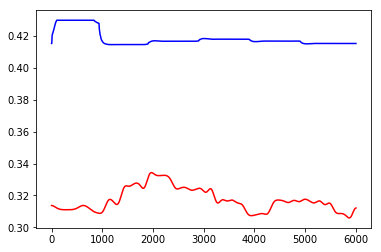

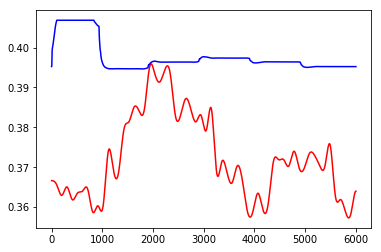

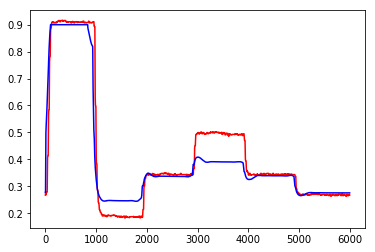

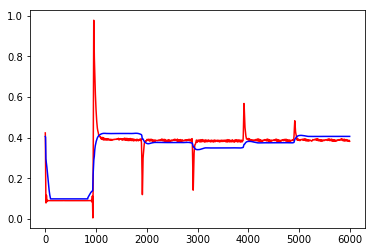

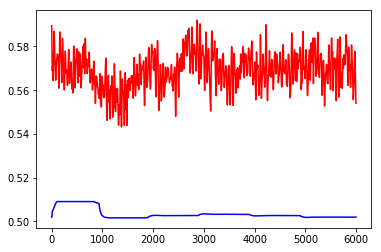

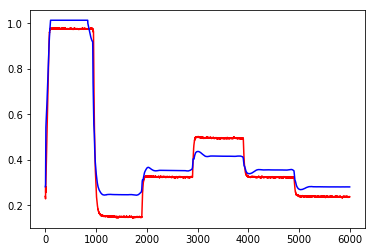

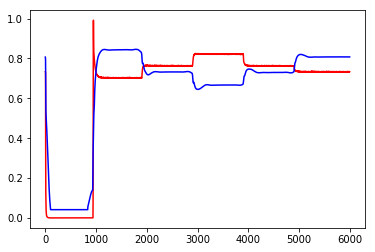

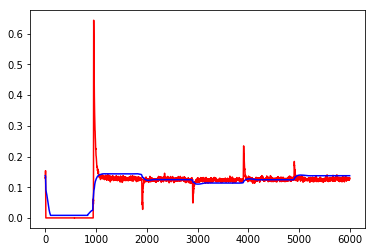

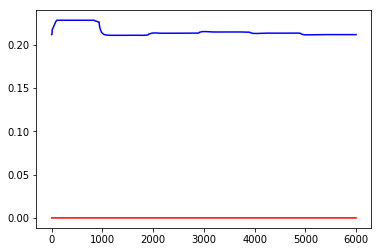

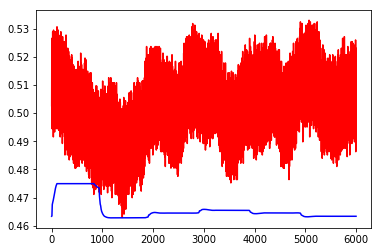

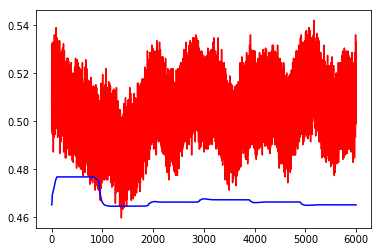

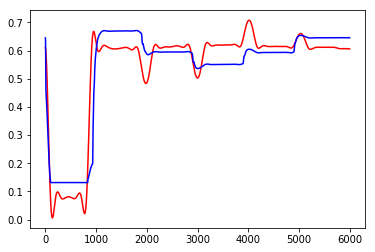

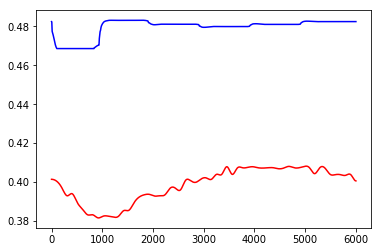

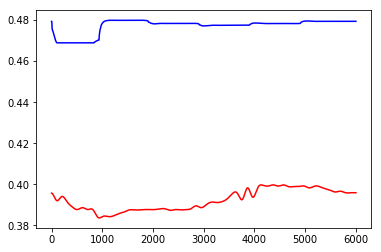

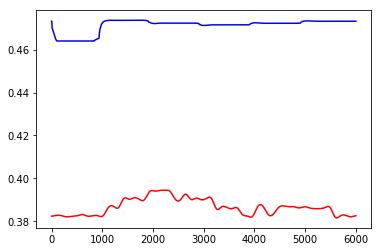

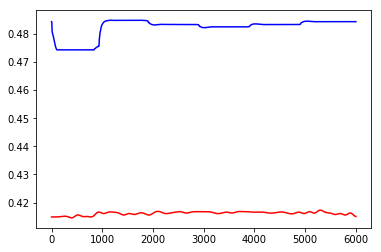

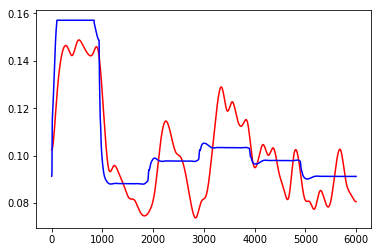

In [11]:
x_values = np.arange(data.shape[1])
x_values2 = np.arange(reconstructed_data.shape[1]) + (data.shape[1] - reconstructed_data.shape[1]) // 2
for idx in range(data.shape[2]):
    plt.figure()
    plt.plot(x_values, data[100, :, idx], 'r', x_values2, reconstructed_data[100, :, idx], 'b')
plt.show()